### Introduction

In this notebook, we will test out install the [llava-v1.6-7b](https://huggingface.co/cjpais/llava-1.6-mistral-7b-gguf) and serving with [LocalAI](https://localai.io/) in SAP AI Core. Enhance [btp-generative-ai-hub-use-cases/01-social-media-citizen-reporting-genai-hub](https://github.com/SAP-samples/btp-generative-ai-hub-use-cases/tree/main/01-social-media-citizen-reporting-genai-hub) with Vision capability powered by the LLaVa models, in which the issues of public facilities reported by citizen can be automatically analyzed by the Vision API with its image. In addition, you can also run Llama 3, Phi 3, Mistral, Mixtral, Gemma and other [supported models in LocalAI](https://localai.io/models/).

### Prerequisites

Before running this notebook, please assure you have performed the [Prerequisites](../../README.md) and [01-deployment.ipynb](01-deployment.ipynb). As a result, a deployment of LocalAI scenario is running in SAP AI Core.<br/><br/>

If the configuration and deployment are created through SAP AI Launchpad, please manually update the configuration_id and deployment_id in [env.json](env.json)
```json
{
    "configuration_id": "<YOUR_CONFIGURATION_ID_OF_LOCALAI_SCENARIO>",
    "deployment_id": "<YOUR_DEPLOYMENT_ID_BASED_ON_CONFIG_ABOVE>"
}
```

### The high-level flow:

- Load configurations info
- Connect to SAP AI Core via SDK
- Check the status and logs of the deployment
- Pull model from ollama model repository through API
- Inference the model with OpenAI-compatible chat completion API


#### 1.Load config info

- resource_group loaded from [config.json](../config.json)
- deployment_id(created in 01-deployment.ipynb) loaded [env.json](env.json)


In [1]:
import requests, json
from ai_api_client_sdk.ai_api_v2_client import AIAPIV2Client

In [2]:
# Please replace the configurations below.
# config_id: The target configuration to create the deployment. Please create the configuration first.
with open("../config.json") as f:
    config = json.load(f)

with open("./env.json") as f:
    env = json.load(f)

deployment_id = env["deployment_id"]
resource_group = config.get("resource_group", "default")
print("deployment id: ", deployment_id, " resource group: ", resource_group)

deployment id:  d09391ae26f8c16d  resource group:  oss-llm


#### 2.Initiate connection to SAP AI Core


In [3]:
aic_sk = config["ai_core_service_key"]
base_url = aic_sk["serviceurls"]["AI_API_URL"] + "/v2/lm"
ai_api_client = AIAPIV2Client(
    base_url=base_url,
    auth_url=aic_sk["url"] + "/oauth/token",
    client_id=aic_sk["clientid"],
    client_secret=aic_sk["clientsecret"],
    resource_group=resource_group,
)

In [4]:
token = ai_api_client.rest_client.get_token()
headers = {
    "Authorization": token,
    "ai-resource-group": resource_group,
    "Content-Type": "application/json",
}

#### 3.Check the deployment status


In [ ]:
# Check deployment status before inference request
deployment_url = f"{base_url}/deployments/{deployment_id}"
response = requests.get(url=deployment_url, headers=headers)
resp = response.json()
status = resp["status"]

deployment_log_url = (
    f"{base_url}/deployments/{deployment_id}/logs?start=2024-03-25T01:35:58"
)


if status == "RUNNING":
    print(f"Deployment-{deployment_id} is running. Ready for inference request")
else:
    print(
        f"Deployment-{deployment_id} status: {status}. Not yet ready for inference request"
    )
    # retrieve deployment logs
    # {{apiurl}}/v2/lm/deployments/{{deploymentid}}/logs.
    response = requests.get(url=deployment_log_url, headers=headers)
    print("Deployment Logs:\n", response.text)

#### 4.Install the model

We'll install [llava-v1.6-mistral-7b.Q5_K_M.gguf] from hugging face into our local-ai server in SAP AI Core through the instruction about [How to install a model (without a gallery)](https://localai.io/models/#how-to-install-a-model-without-a-gallery). <br/>In addition, llava also comes with 13b and 34b models with higher accuracy, also required more resources. Please change the corresponding resource plan in byom-oss-llm-templates/local-ai-template.yaml

- **llava:13b** Please change resource plan into **infer.m** or **infer.l** in [/byom-oss-llm-templates/local-ai-template.yaml](../byom-oss-llm-templates/local-ai-template.yaml)
- **llava:34b** Please change resource plan into **infer.l** in [/byom-oss-llm-templates/local-ai-template.yaml](../byom-oss-llm-templates/local-ai-template.yaml)


In [6]:
model = "llava"  # llava-v1.6-7b
# model = "llava:13b" #Important: please change resource plan into infer.m in byom-oss-llm-templates/local-ai-template.yaml
# model = "llava:34b" #Important: please change resource plan into infer.l in byom-oss-llm-templates/local-ai-template.yaml

deployment = ai_api_client.deployment.get(deployment_id)
inference_base_url = f"{deployment.deployment_url}/v1"

##### 4.1 Install the model and override the base config

In [83]:
# Install model from hugging face without model config.GPU is not enabled by default.
# In this example, let's override the configuration with GPU enabled while downloading the model from hugging face.
# Please refer to this for find out your target model: https://localai.io/models/#how-to-install-a-model-from-the-repositories
install_model_endpoint = f"{inference_base_url}/models/apply"
print(install_model_endpoint)

json_data = {
    "url": "github:go-skynet/model-gallery/base.yaml",
    "name": model,  # rename the model
    "files": [
        {
            "uri": "https://huggingface.co/cjpais/llava-1.6-mistral-7b-gguf/resolve/main/llava-v1.6-mistral-7b.Q5_K_M.gguf",
            "sha256": "b1d37fc65ecb80aa8f1ce185bf4d7605bc3c5cc5bcc77a160c3a1b0377631112",
            "filename": "llava-v1.6-mistral-7b.Q5_K_M.gguf"
        },
        {
            "uri": "https://huggingface.co/cjpais/llava-1.6-mistral-7b-gguf/resolve/main/mmproj-model-f16.gguf",
            "sha256": "00205ee8a0d7a381900cd031e43105f86aa0d8c07bf329851e85c71a26632d16",
            "filename": "mmproj-model-f16.gguf"
        }
        # {
        #     "uri": "https://raw.githubusercontent.com/mudler/LocalAI/master/examples/configurations/llava/chat-simple.tmpl",
        #     "sha256": "",
        #     "filename": "chat-simple.tmpl"
        # }
    ],
    # Override with GPU enabled.
    "overrides": {
        "backend": "llama-cpp",
        "f16": True, 
        "mmap": True, 
        "gpu_layers": 90, 
        "threads": 3,
        "roles": {
            "user": "USER:",
            "assistant": "ASSISTANT:",
            "system": "SYSTEM:"
            },
        "parameters": { 
            "model": "llava-v1.6-mistral-7b.Q5_K_M.gguf"
            },
        "template": {
            "chat": "chat-simple" 
            },
        "mmproj": "mmproj-model-f16.gguf",
        "prompt_templates": {
            "name": "chat-simple",
            "content": "<|im_start|>{{if eq .RoleName \"assistant\"}}assistant{{else if eq .RoleName \"system\"}}system{{else if eq .RoleName \"user\"}}user{{end}} \
{{if .Content}}{{.Content}}{{end}} \
<|im_end|>"
        }
    }
}

response = requests.post(install_model_endpoint, headers=headers, json=json_data)
install_model_resp_json = response.json()
job_id = install_model_resp_json["uuid"]
print("Result:", install_model_resp_json)

https://api.ai.prod.eu-central-1.aws.ml.hana.ondemand.com/v2/inference/deployments/d09391ae26f8c16d/v1/models/apply
Result: {'uuid': '3993b81c-ebfa-11ee-ba84-463fc5800695', 'status': 'http://d09391ae26f8c16d-predictor-default.rg-2ac5c88d-3284ef4c.svc.cluster.local/models/jobs/3993b81c-ebfa-11ee-ba84-463fc5800695'}


##### 4.2 Check the job status of model installation

In [96]:
# Checking status of installing model
endpoint = f"{inference_base_url}/models/jobs/{job_id}"
response = requests.get(url=endpoint, headers=headers)
print("Model Installation Job Logs:\n", response.text)

Model Installation Job Logs:
 {"file_name":"","error":null,"processed":true,"message":"completed","progress":100,"file_size":"","downloaded_size":""}


##### 4.3 Check if the target model(llava) listed in the model list.

In [65]:
# List models and found out the model id, which will  be used in next request on chat completion
endpoint = f"{inference_base_url}/v1/models"
print(endpoint)

response = requests.get(endpoint, headers=headers)
print("Result:", response.text)

https://api.ai.prod.eu-central-1.aws.ml.hana.ondemand.com/v2/inference/deployments/d09391ae26f8c16d/v1/v1/models
Result: {"object":"list","data":[{"id":"mistral","object":"model"},{"id":"llava","object":"model"},{"id":"ggml-gpt4all-j.bin","object":"model"},{"id":"mmproj-model-f16.gguf","object":"model"}]}


#### 5.Inference Vision API

In the following samples, we'll enhance [btp-generative-ai-hub-use-cases/01-social-media-citizen-reporting](https://github.com/SAP-samples/btp-generative-ai-hub-use-cases/tree/main/01-social-media-citizen-reporting) with Vision API powered by the LLaVa model. Please refer to LocalAI's manual about [GPT Vision API](https://localai.io/features/gpt-vision/) for details.

In [29]:
openai_chat_api_endpoint = f"{inference_base_url}/v1/chat/completions"

##### 5.1 Vision Sample#1: Describe the image (a cracked bridge)

Let's start with a simple question to ask the model to describe the image in nature language.<br/><br/>
Display the sample image.


In [ ]:
from IPython.display import display, Image

# URL of the image
# To replace an image with raw image url
image_url = "https://raw.githubusercontent.com/SAP-samples/btp-generative-ai-hub-use-cases/32f16df36df31ea01afe8d47e82a26d8d27e1d94/10-byom-oss-llm-ai-core/resources/10-bridge-crack.png"

# Display the image
display(Image(url=image_url))

In [81]:
user_msg = "What is in the image?"
image_url = ""
json_data = {
    "model": model,
    "messages": [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": user_msg},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": image_url
                    },
                },
            ],
            "temperature": 0.9,
        }
    ],
    "stream": False,  # not streaming
}

response = requests.post(url=openai_chat_api_endpoint, headers=headers, json=json_data)
print("Result:", response.text)

Result: {"created":1711456731,"object":"chat.completion","id":"f9eecc4d-49e5-4c6f-86c7-12a9ca99b653","model":"llava","choices":[{"index":0,"finish_reason":"stop","message":{"role":"assistant","content":"\n\nThis image is a photograph of a concrete overpass with a large crack in the middle of the support column. The overpass is supported by two columns, and the crack is visible between them. The sky is blue, and there are some clouds in the distance. The ground appears to be dry and there are some vehicles parked underneath the overpass. There are no people visible in the image. The photograph is taken from a low angle, looking up at the overpass. "}}],"usage":{"prompt_tokens":0,"completion_tokens":0,"total_tokens":0}}


##### 5.2 Vision Sample#2: Public Facilities Issue Spotter for [Citizen Reporting use case](https://github.com/SAP-samples/btp-generative-ai-hub-use-cases/tree/main/01-social-media-citizen-reporting) (e.g. Bridge Damage)

In next sample, we'll ask the llava model to be an Assistant of Public Facilities Issue Spotter for city council.
Responsible for analyzing images reported by citizens through a mobile app to identify issues related to public facilities. <br/>
Here are the tasks: <br/>

- 1.Analyze images reported by citizens through a mobile app to identify issues related to public facilities. If no issue identified, go to step 5, otherwise continue with next steps
- 2.Extract photographic date and location information from images for accurate documentation.
- 3.Categorize identified issues based on predefined categories (e.g., infrastructure damage, cleanliness, safety hazards).
- 4.Assess the severity and priority of identified issues to determine appropriate action plans.
- 5.Output with JSON schema in triple quote as below:

```json
{ "issue_identified": "{{true or false}}",
#below section only output when there is an issue identified
"title": "{{A title about the issue less than 100 characters}}",
"description": "{{A short description about the issue less than 300 characters}}",
"photo_date": "{{Extracted photographic date from its metadata in yyyy-mm-dd:hh:mm:ss format}}",
"longitude": "{{Extracted the longitude of photographic location from its metadata. Output -1 if fails to extract location info from image}}",
"latitude": "{{Extracted the latitude of photographic location from its metadata. Output -1 if fails to extract location info from image}}",
"category": "{{Identified category: 01-Infrastructure Damage, 02-Cleanliness, 03-Safety Hazards, 04-Duplicated}}",
"priority": "{{Identified priority: 01-Very High, 02-High, 03-Medium, 04-Low}}",
"suggested_action": "{{01-Immediate Attendance, 02-Schedule Inspection, 03-Schedule Service, 04-Refer to similar issue}}"
}
```


In [101]:
user_msg = r'''
You are a helpful Assistant of Public Facilities Issue Spotter for city council.
Responsible for analyzing images reported by citizens through a mobile app to identify issues related to public facilities. 
Here are your tasks:
1.Analyze images reported by citizens through a mobile app to identify issues related to public facilities. 
If no issue identified, go to step 5, otherwise continue with next steps 
2.Extract photographic date and location information from images for accurate documentation. 
3.Categorize identified issues based on predefined categories (e.g., infrastructure damage, cleanliness, safety hazards).
4.Assess the severity and priority of identified issues to determine appropriate action plans. 
5.Output with JSON schema in triple quote as below:
\"\"\" 
{ \"issue_identified\": \"{{true or false}}\", 
#below section only output when there is an issue identified\
\"title\": \"{{A short title about the issue}}\", 
\"description\": \"{{A detail description about the issue}}\", 
\"photo_date\": \"{{Extracted photographic date from its metadata in yyyy-mm-dd:hh:mm:ss format. Leave it blank if no metadata found in it.}}\", 
\"longitude\": \"{{Extracted longitude of photographic location from its metadata. Do not make up any number. Output -1 if fails to extract location info from image}}\",
\"latitude\": \"{{Extracted latitude of photographic location from its metadata. Do not make up any number. Output -1 if fails to extract location info from image}}\",
\"category\": \"{{Identified category: 01-Infrastructure Damage, 02-Cleanliness, 03-Safety Hazards, 04-Duplicated}}\",
\"priority\": \"{{Suggested Priority: 01-Very High, 02-High, 03-Medium, 04-Low}}\",
\"suggested_action\": \"{{01-Immediate Attendance, 02-Schedule Inspection, 03-Schedule Service, 04-Refer to similar issue }}\"
} 
\"\"\"
'''

json_data = {
    "model": model,
    "response_format": {"type": "json_object"},
    "messages": [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": user_msg},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": image_url
                    },
                },
            ],
            "temperature": 0.9,
        }
    ],
    "stream": False,  # not streaming
}

response = requests.post(url=openai_chat_api_endpoint, headers=headers, json=json_data)
print("Result:", response.text)

Result: {"created":1711456731,"object":"chat.completion","id":"f9eecc4d-49e5-4c6f-86c7-12a9ca99b653","model":"llava","choices":[{"index":0,"finish_reason":"stop","message":{"role":"assistant","content":"\n\nThis image is a photograph of a concrete overpass with a large crack in the center of the support column. The overpass is part of a highway system, and the sky is clear and blue. The photograph is taken from a low angle, looking up at the underside of the overpass. The crack in the column is large and appears to be a significant structural issue. There are no people visible in the image. "}}],"usage":{"prompt_tokens":0,"completion_tokens":0,"total_tokens":0}}


##### 5.3 Vision Sample#3: Describe the image (e.g. a dirty street)

Let's continue with another sample image about a dirty street, asking the model to describe the image in nature language.


Display the sample image


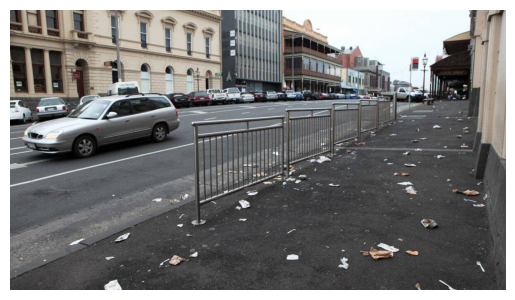

In [67]:
image_url = "https://raw.githubusercontent.com/SAP-samples/btp-generative-ai-hub-use-cases/main/10-byom-oss-llm-ai-core/resources/11-dirty-street.jpg"
# Display the image
display(Image(url=image_url))

Let's ask it to spots on the public facility issue in the image, and Describe the issue in detail if any.


In [102]:
user_msg = "Spots on the public facility issue in the image, and Describe the issue in detail if any"

json_data = {
    "model": model,
    "messages": [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": user_msg},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": image_url
                    },
                },
            ],
            "temperature": 0.9,
        }
    ],
    "stream": False,  # not streaming
}

response = requests.post(url=openai_chat_api_endpoint, headers=headers, json=json_data)
print("Result:", response.text)

Result: {"created":1711456731,"object":"chat.completion","id":"f9eecc4d-49e5-4c6f-86c7-12a9ca99b653","model":"llava","choices":[{"index":0,"finish_reason":"stop","message":{"role":"assistant","content":"\n\nThis image is a photograph of a concrete overpass with a large crack in the center of the support column. The overpass is part of a highway system, and the sky is clear and blue. The photograph is taken from a low angle, looking up at the underside of the overpass. The crack in the column is large and appears to be a significant structural issue. There are no people visible in the image. "}}],"usage":{"prompt_tokens":0,"completion_tokens":0,"total_tokens":0}}


##### 5.4 Vision Sample#4: Public Facilities Issue Spotter for [Citizen Reporting use case](https://github.com/SAP-samples/btp-generative-ai-hub-use-cases/tree/main/01-social-media-citizen-reporting) (e.g. a dirty street)

In next sample, we'll ask the llava model to be an Assistant of Public Facilities Issue Spotter for city council.
Responsible for analyzing images reported by citizens through a mobile app to identify issues related to public facilities. <br/>
Here are the tasks: <br/>

- 1.Analyze images reported by citizens through a mobile app to identify issues related to public facilities. If no issue identified, go to step 5, otherwise continue with next steps
- 2.Extract photographic date and location information from images for accurate documentation.
- 3.Categorize identified issues based on predefined categories (e.g., infrastructure damage, cleanliness, safety hazards).
- 4.Assess the severity and priority of identified issues to determine appropriate action plans.
- 5.Output with JSON schema in triple quote as below:

```json
{ "issue_identified": "{{true or false}}",
#below section only output when there is an issue identified
"title": "{{A title about the issue less than 100 characters}}",
"description": "{{A short description about the issue less than 300 characters}}",
"photo_date": "{{Extracted photographic date from its metadata in yyyy-mm-dd:hh:mm:ss format}}",
"longitude": "{{Extracted the longitude of photographic location from its metadata. Output -1 if fails to extract location info from image}}",
"latitude": "{{Extracted the latitude of photographic location from its metadata. Output -1 if fails to extract location info from image}}",
"category": "{{Identified category: 01-Infrastructure Damage, 02-Cleanliness, 03-Safety Hazards, 04-Duplicated}}",
"priority": "{{Identified priority: 01-Very High, 02-High, 03-Medium, 04-Low}}",
"suggested_action": "{{01-Immediate Attendance, 02-Schedule Inspection, 03-Schedule Service, 04-Refer to similar issue}}"
}
```


In [72]:
user_msg = r'''
You are a helpful Assistant of Public Facilities Issue Spotter for city council.
Responsible for analyzing images reported by citizens through a mobile app to identify issues related to public facilities. 
Here are your tasks:
1.Analyze images reported by citizens through a mobile app to identify issues related to public facilities. 
If no issue identified, go to step 5, otherwise continue with next steps 
2.Extract photographic date and location information from images for accurate documentation. 
3.Categorize identified issues based on predefined categories (e.g., infrastructure damage, cleanliness, safety hazards).
4.Assess the severity and priority of identified issues to determine appropriate action plans. 
5.Output with JSON schema in triple quote as below:
\"\"\" 
{ \"issue_identified\": \"{{true or false}}\", 
#below section only output when there is an issue identified\
\"title\": \"{{A short title about the issue}}\", 
\"description\": \"{{A detail description about the issue}}\", 
\"photo_date\": \"{{Extracted photographic date from its metadata in yyyy-mm-dd:hh:mm:ss format. Leave it blank if no metadata found in it.}}\", 
\"longitude\": \"{{Extracted longitude of photographic location from its metadata. Do not make up any number. Output -1 if fails to extract location info from image}}\",
\"latitude\": \"{{Extracted latitude of photographic location from its metadata. Do not make up any number. Output -1 if fails to extract location info from image}}\",
\"category\": \"{{Identified category: 01-Infrastructure Damage, 02-Cleanliness, 03-Safety Hazards, 04-Duplicated}}\",
\"priority\": \"{{Suggested Priority: 01-Very High, 02-High, 03-Medium, 04-Low}}\",
\"suggested_action\": \"{{01-Immediate Attendance, 02-Schedule Inspection, 03-Schedule Service, 04-Refer to similar issue }}\"
} 
\"\"\"
'''

json_data = {
    "model": model,
    "messages": [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": user_msg},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": image_url
                    },
                },
            ],
            "temperature": 0.9,
        }
    ],
    "stream": False,  # not streaming
}

response = requests.post(url=openai_chat_api_endpoint, headers=headers, json=json_data)
print("Result:", response.text)

Result: {"model":"llava","created_at":"2024-03-26T03:27:32.937728263Z","message":{"role":"assistant","content":"{\"issue_identified\": true,\n \"title\": \"Trash-filled sidewalk by the road\", \"description\": \"The sidewalk on the side of the street is littered with discarded trash and items, posing a cleanliness issue and potential safety hazard.\", \"photo_date\": \"2023-05-14:18:05\", \"longitude\": -167, \"latitude\": -39.723, \"category\": \"02-Cleanliness\", \"priority\": \"03-Medium\", \"suggested_action\": \"03-Schedule Service\"} "},"done":true,"total_duration":5165857364,"load_duration":1866237,"prompt_eval_count":1,"prompt_eval_duration":2045334000,"eval_count":138,"eval_duration":3094746000}
